In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES, 
from anomaly.utils import specobjid_to_idx
from sdss.metadata import MetaData
from autoencoders.ae import AutoEncoder

meta = MetaData()

In [28]:
bin_id = "bin_03"
model_id = "0002"
architecture = "256_128_64/latent_12"

meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"

scores_directory = (
    f"{meta_data_directory}/{bin_id}/explanation/256_128_64/latent_12"
)

model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}"

wave = np.load(f"{meta_data_directory}/wave.npy")
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")

ids = np.load(
    f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy"
)

model = AutoEncoder(
    reload=True, reload_from=f"{model_directory}/{model_id}"
)

In [29]:
def compare(spectra_idx, spectra):
    observation = spectra[spectra_idx]
    reconstruction = model.reconstruct(observation).reshape(-1)
    residual = np.abs(observation - reconstruction)

    return observation, reconstruction, residual

In [30]:
## Get sets of specobjids of anomalous spectra per score
scores_names = [
    "mse_noRel100",
    "mse_filter_250kms_noRel100",
    "mse_noRel97",
    "mse_filter_250kms_noRel97",
    "mse_rel100",
    "mse_filter_250kms_rel100",
    "mse_rel97",
    "mse_filter_250kms_rel97",
]

In [31]:
df_scores = {}

for score_name in scores_names:

    df_scores[score_name] = pd.read_csv(
        f"{scores_directory}/{score_name}/top_anomalies.csv.gz",
        index_col="specobjid",
    )

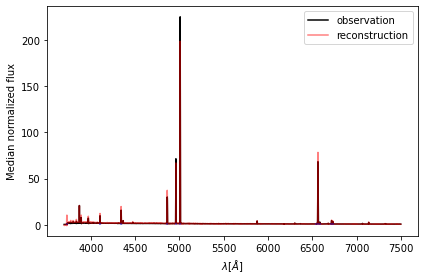

In [32]:
show_lines = True
fig, ax = plt.subplots(tight_layout=True)
specobjid = df_scores["mse_noRel100"].index[-1]
idx = specobjid_to_idx(specobjid, ids)

observation, reconstruction, residual = compare(idx, spectra)
ax.clear()
ax.set_ylabel("Median normalized flux")
ax.set_xlabel("$\lambda [\AA]$")

ax.plot(wave, observation, c="black", label="observation")
ax.plot(
    wave, reconstruction, c="red", label="reconstruction", alpha=0.5
)
ax.legend()

if show_lines is True:
    for line in GALAXY_LINES:
        ax.vlines(
            GALAXY_LINES[line],
            ymin=0,
            ymax=2*np.median(observation),
            color="blue",
            alpha=0.4,
        )


Save anomalies

KeyboardInterrupt: 

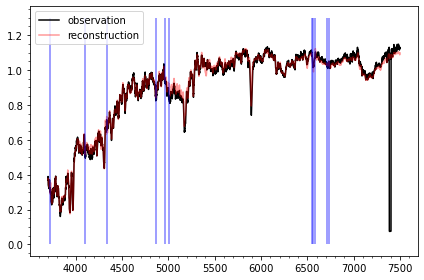

In [33]:
image_format = "pdf"

show_lines = True
fig, ax = plt.subplots(tight_layout=True)

for score in scores_names:

    save_to = f"/home/edgar/Downloads/score/{score}/anomaly"

    if os.path.exists(save_to) is False:
        os.makedirs(save_to)

    for rank in range(1, 1000):

        specobjid = df_scores[score].index[-rank]
        idx = specobjid_to_idx(specobjid, ids)

        observation, reconstruction, residual = compare(idx, spectra)
        ax.clear()

        # ax.set_ylabel("Median normalized flux")
        ax.minorticks_on()

        ax.plot(wave, observation, c="black", label="observation")

        ax.plot(
            wave, reconstruction,
            c="red", label="reconstruction",
            alpha=0.4
        )

        ax.legend()

        if show_lines is True:
            for line in GALAXY_LINES:
                ax.vlines(
                    GALAXY_LINES[line],
                    ymin=0,
                    ymax=1.3*np.median(observation),
                    color="blue",
                    alpha=0.5
                )

        fig.savefig(f"{save_to}/{rank:04d}.{image_format}")

Save normal spectra 

In [34]:
df_normal_scores = {}

for score_name in scores_names:

    df_normal_scores[score_name] = pd.read_csv(
        f"{scores_directory}/{score_name}/top_normal.csv.gz",
        index_col="specobjid",
    )

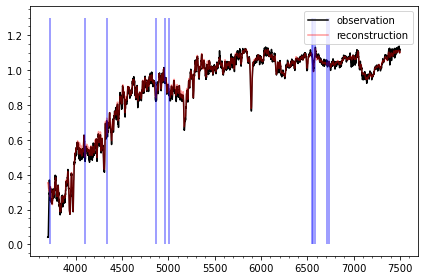

In [35]:
image_format = "pdf"

show_lines = True
fig, ax = plt.subplots(tight_layout=True)

for score in scores_names:

    save_to = f"/home/edgar/Downloads/score/{score}/normal"

    if os.path.exists(save_to) is False:
        os.makedirs(save_to)

    for rank in range(0, 100):

        specobjid = df_normal_scores[score].index[rank]
        idx = specobjid_to_idx(specobjid, ids)

        observation, reconstruction, residual = compare(idx, spectra)
        ax.clear()

        # ax.set_ylabel("Median normalized flux")
        ax.minorticks_on()

        ax.plot(wave, observation, c="black", label="observation")

        ax.plot(
            wave, reconstruction,
            c="red", label="reconstruction",
            alpha=0.4
        )

        ax.legend()

        if show_lines is True:
            for line in GALAXY_LINES:
                ax.vlines(
                    GALAXY_LINES[line],
                    ymin=0,
                    ymax=1.3*np.median(observation),
                    color="blue",
                    alpha=0.5
                )

        fig.savefig(f"{save_to}/{rank:04d}.{image_format}")